#Installations and importing

In [308]:
!pip install transformers

In [323]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

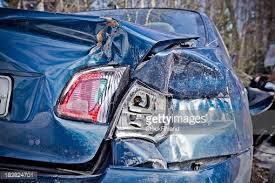

In [324]:
from PIL import Image
import requests

url = "/content/0206.JPEG"
# url = '/content/car1.jfif'
image = Image.open(url)
image

## Checking the damage and is it a vehicle

In [325]:
import torch

prompts = ['damaged', 'car']

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

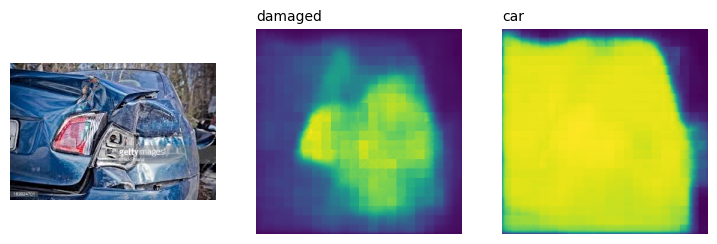

In [326]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [327]:
preds[0][0].shape

torch.Size([352, 352])

In [328]:
preds.shape[0]

2

In [329]:
threshold = 0.4

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_damage_preds_with_treshold = torch.full((2, flat_preds.shape[-1]), threshold)
flat_car_preds_with_treshold = torch.full((2, flat_preds.shape[-1]), threshold)
# print(flat_preds_with_treshold)



In [330]:
print(flat_preds.shape)
print(flat_preds[0].shape)

torch.Size([2, 123904])
torch.Size([123904])


In [331]:
car_prediction = flat_preds[1]
damage_pred = flat_preds[0]

## Checking thresholds of vehicle prediction

(array([11113.,  3463.,  2876.,  2201.,  1641.,  1653.,  2224.,  3639.,
        10283., 84811.]),
 array([4.89704951e-04, 9.36587900e-02, 1.86827883e-01, 2.79996961e-01,
        3.73166054e-01, 4.66335148e-01, 5.59504211e-01, 6.52673304e-01,
        7.45842397e-01, 8.39011490e-01, 9.32180583e-01]),
 <BarContainer object of 10 artists>)

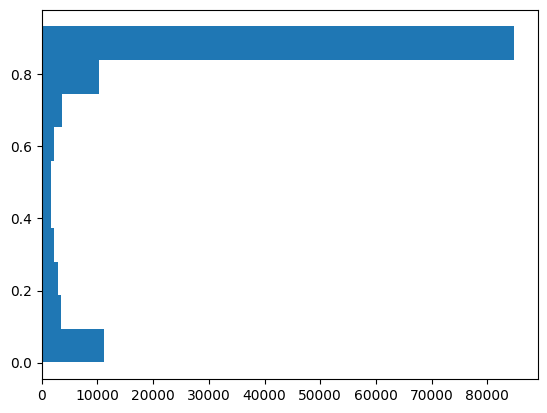

In [332]:
import matplotlib.pyplot as plt

plt.hist(flat_preds[1], orientation='horizontal')

## Checking thresholds of damage prediction

(array([19189., 27031., 19411.,  8733.,  7108.,  6681.,  5730., 12031.,
        15293.,  2697.]),
 array([0.00184847, 0.05372835, 0.10560822, 0.15748809, 0.20936798,
        0.26124784, 0.31312773, 0.36500761, 0.41688746, 0.46876734,
        0.52064723]),
 <BarContainer object of 10 artists>)

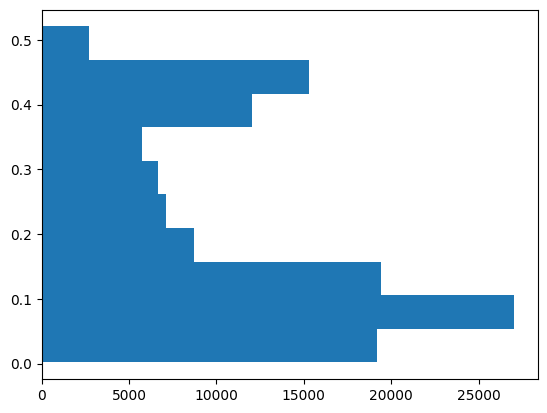

In [333]:
import matplotlib.pyplot as plt

plt.hist(flat_preds[0], orientation='horizontal')

In [334]:
flat_damage_preds_with_treshold[1:1+1,:] = flat_preds[0]
flat_car_preds_with_treshold[1:1+1,:] = flat_preds[1]

# print(flat_preds_with_treshold)

flat_damage_preds_with_treshold.shape

torch.Size([2, 123904])

## Creating segment indexes of damage and vehicle

In [335]:
# Get the top mask index for each pixel
inds = torch.topk(flat_damage_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
car_inds = torch.topk(flat_car_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
print(inds)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [344]:
len(inds)

352

## Finding the coordinates of damage area

In [396]:

import numpy as np
def return_boundingbox(segment_indexs):
  x_points = []
  y_points = []
  for y, list_val in enumerate(segment_indexs):
    for x, val in enumerate(list_val):
      if val == 1:
        x_points.append(x)
        y_points.append(y)
  return np.min(x_points), np.min(y_points), np.max(x_points), np.max(y_points)

In [392]:
x1, y1, x2, y2 = return_boundingbox(inds)

In [393]:
print(x1, y1, x2, y2)

76 96 296 303


In [371]:
# inds.dtype = float
float_inds = inds.float()

In [394]:
import torch
import torchvision
import torchvision.transforms as T

from PIL import ImageDraw

transform = T.ToPILImage()
img = transform(float_inds)

draw = ImageDraw.Draw(img)
# draw.rectangle(xy=)
draw.rectangle(((x1, y1), (x2, y2)), outline='red')

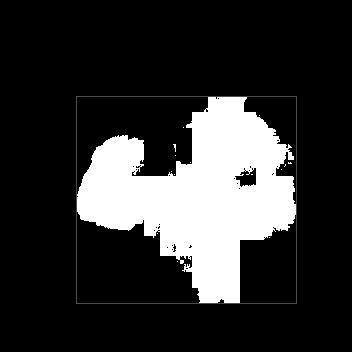

In [395]:
img

(array([[352.,   0.,   0., ...,   0.,   0.,   0.],
        [352.,   0.,   0., ...,   0.,   0.,   0.],
        [352.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [352.,   0.,   0., ...,   0.,   0.,   0.],
        [352.,   0.,   0., ...,   0.,   0.,   0.],
        [352.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 352 BarContainer objects>)

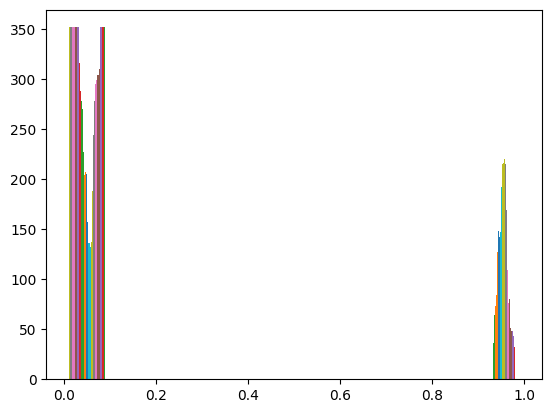

In [340]:
import matplotlib.pyplot as plt

plt.hist(inds)
# plt.plot(inds)

## Segment of damage

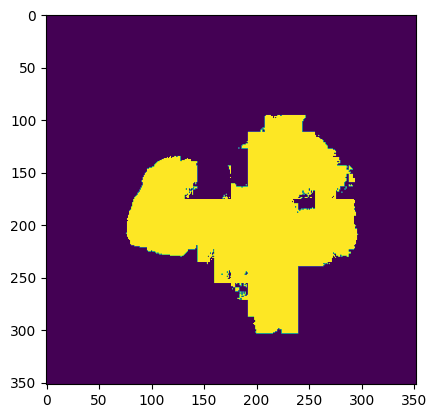

In [397]:
plt.imshow(inds)


## Segment of vehicle

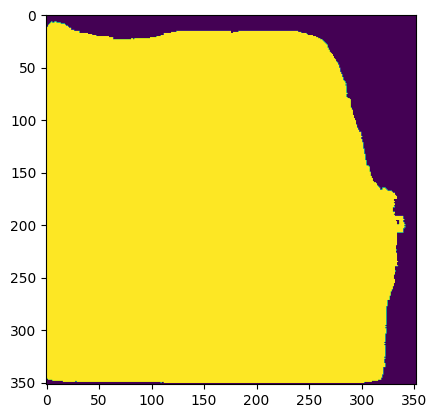

In [339]:
plt.imshow(car_inds)